In [8]:
#@title Install & Imports
!pip -q install lightgbm imbalanced-learn plotly==5.* --upgrade

import os, json, gc, re, warnings, shutil
from pathlib import Path
from typing import List, Optional
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
try: pio.renderers.default = "colab"
except Exception: pio.renderers.default = "notebook_connected"

from google.colab import drive
drive.mount('/content/drive')

# 🔁 Use the shared drive name and folder structure
SHARED_DRIVE = "CMPE_279_Anamoly_Detection"
PROJECT_DIR  = "Project"

# 🔧 Set main directory path
DRIVE_DIR = f"/content/drive/MyDrive/{SHARED_DRIVE}/{PROJECT_DIR}"

# 📂 Define dataset paths
RAW_CSV        = f"{DRIVE_DIR}/ACI-IoT-2023.csv"

DATA_DIR = "/content/preprocessed_iot"
OUT_DIR  = Path(DATA_DIR); OUT_DIR.mkdir(parents=True, exist_ok=True)

# ✅ Ensure folder exists
import os
os.makedirs(DRIVE_DIR, exist_ok=True)
print("Using folder:", DRIVE_DIR)
# Paths
ARTIFACTS_DIR = Path("/content/artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print("Artifacts dir:", ARTIFACTS_DIR)

# Data
INPUT_CSV   = RAW_CSV
LABEL_COL   = "Label"

# Reproducibility & sizes
RANDOM_STATE = 42
TEST_SIZE    = 0.20
VAL_SIZE     = 0.20

# Balanced subset parameters (per-class sampling)
FRAC_PER_CLASS = 0.12
CAP_PER_CLASS  = 25000
MIN_PER_CLASS  = 500

# Selected numeric features (as requested)
SELECTED_FEATURES = [
    'Src Port', 'Dst Port', 'Flow Duration', 'Total Length of Fwd Packet',
    'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Flow IAT Min',
    'Fwd IAT Min', 'Fwd Header Length', 'Bwd Packets/s', 'Packet Length Max',
    'Packet Length Std', 'RST Flag Count', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
    'Idle Mean', 'Idle Max'
]

DTYPE_FLOAT = "float32"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using folder: /content/drive/MyDrive/CMPE_279_Anamoly_Detection/Project
Artifacts dir: /content/artifacts


In [13]:
#@title 🧹 Preprocess → balanced subset → splits → scaling → save schema

def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    need = SELECTED_FEATURES + [LABEL_COL]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"Missing required columns: {miss}")
    df = df[need]
    df = df.replace([np.inf, -np.inf], np.nan)
    for c in SELECTED_FEATURES:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].median()).astype(DTYPE_FLOAT)
    df[LABEL_COL] = df[LABEL_COL].astype(str)
    return df

def build_balanced_subset(df: pd.DataFrame) -> pd.DataFrame:
    parts = []
    for y, g in df.groupby(LABEL_COL):
        want = int(np.ceil(len(g) * FRAC_PER_CLASS))
        want = max(MIN_PER_CLASS, min(CAP_PER_CLASS, want))
        parts.append(g.sample(n=want, replace=(len(g) < want), random_state=RANDOM_STATE))
    return (pd.concat(parts)
            .sample(frac=1.0, random_state=RANDOM_STATE)
            .reset_index(drop=True))

def split_keep_all(df: pd.DataFrame, tries: int = 200):
    y = df[LABEL_COL].values
    classes = set(df[LABEL_COL].unique())
    rng = np.random.RandomState(RANDOM_STATE)
    for _ in range(tries):
        s1 = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=rng.randint(1e6))
        tr_idx, te_idx = next(s1.split(np.zeros(len(df)), y))
        tr_tmp, te = df.iloc[tr_idx].reset_index(drop=True), df.iloc[te_idx].reset_index(drop=True)
        s2 = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=rng.randint(1e6))
        tr2_idx, va_idx = next(s2.split(np.zeros(len(tr_tmp)), tr_tmp[LABEL_COL].values))
        tr, va = tr_tmp.iloc[tr2_idx].reset_index(drop=True), tr_tmp.iloc[va_idx].reset_index(drop=True)
        if classes == set(tr[LABEL_COL]) == set(va[LABEL_COL]) == set(te[LABEL_COL]):
            return tr, va, te
    raise RuntimeError("Could not split while retaining all classes. Increase sampling.")

def oversample_equal(train_df: pd.DataFrame) -> pd.DataFrame:
    rng = np.random.default_rng(RANDOM_STATE)
    groups = {k:g for k,g in train_df.groupby(LABEL_COL)}
    m = max(len(v) for v in groups.values())
    parts=[]
    for k,g in groups.items():
        add = m - len(g)
        if add > 0:
            idx = rng.choice(g.index.to_numpy(), size=add, replace=True)
            parts.append(pd.concat([g, train_df.loc[idx]], axis=0))
        else:
            parts.append(g)
    return pd.concat(parts).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

def assert_nondegenerate(frame: pd.DataFrame, where: str):
    X = frame[SELECTED_FEATURES].to_numpy()
    if not np.isfinite(X).all():
        raise ValueError(f"[{where}] Non-finite values after cleaning.")
    stds = X.std(axis=0)
    bad = [SELECTED_FEATURES[i] for i,s in enumerate(stds) if s == 0.0]
    if bad:
        raise ValueError(f"[{where}] Zero-variance features: {bad}")

# 1) load
raw = pd.read_csv(INPUT_CSV)
raw = clean_df(raw)

# 2) balanced subset
balanced = build_balanced_subset(raw)

# 3) stratified splits (all classes preserved)
train_df, val_df, test_df = split_keep_all(balanced)

# Save original (before oversampling)
train_df.to_csv(OUT_DIR/"ftt_train_before.csv", index=False)

# Equalize only the train set
train_bal = oversample_equal(train_df)

# Save balanced (after oversampling)
train_bal.to_csv(OUT_DIR/"ftt_train.csv", index=False)


# 4) equalize TRAIN only (optional but helpful)
train_bal = oversample_equal(train_df)

# 5) sanity checks
for nm, df_ in [("train", train_bal), ("val", val_df), ("test", test_df)]:
    assert_nondegenerate(df_, nm)

# 6) scale numerics (fit on train_bal)
scaler = StandardScaler().fit(train_bal[SELECTED_FEATURES])
for df_ in (train_bal, val_df, test_df):
    df_[SELECTED_FEATURES] = scaler.transform(df_[SELECTED_FEATURES]).astype(DTYPE_FLOAT)

# 7) save splits + schema
train_bal.to_csv(OUT_DIR/"ftt_train.csv", index=False)
val_df.to_csv(OUT_DIR/"ftt_val.csv", index=False)
test_df.to_csv(OUT_DIR/"ftt_test.csv", index=False)

classes = sorted(train_bal[LABEL_COL].unique().tolist())
(OUT_DIR/"classes.json").write_text(json.dumps(classes, indent=2))
(OUT_DIR/"schema.json").write_text(json.dumps(
    {"num_cols": SELECTED_FEATURES, "cat_cols": []}, indent=2))
joblib.dump({"num_cols": SELECTED_FEATURES, "cat_cols": [], "scaler": scaler},
            OUT_DIR/"ftt_scaler.joblib")

print("✅ Preprocess complete.")
print("Train/Val/Test sizes:", len(train_bal), len(val_df), len(test_df))
print("Per-class (train):"); print(train_bal[LABEL_COL].value_counts().sort_index())


✅ Preprocess complete.
Train/Val/Test sizes: 192000 16669 20836
Per-class (train):
Label
ARP Spoofing          16000
Benign                16000
DNS Flood             16000
Dictionary Attack     16000
ICMP Flood            16000
OS Scan               16000
Ping Sweep            16000
Port Scan             16000
SYN Flood             16000
Slowloris             16000
UDP Flood             16000
Vulnerability Scan    16000
Name: count, dtype: int64


In [14]:
#@title 📈 Minimal, high-value plotting (HTML files)

PLOT_SAMPLE_MAX      = 20000
TOP_NUMERIC_K        = 4
PLOT_DIR = OUT_DIR  # write HTMLs next to splits

def _maybe_sample(df, n=PLOT_SAMPLE_MAX):
    return df if len(df) <= n else df.sample(n=n, random_state=RANDOM_STATE)

def plot_class_bars(tr_before: pd.DataFrame, tr_after: pd.DataFrame):
    for frame, tag, title in [
        (tr_before, "before", "Train Class Distribution (Before Balance)"),
        (tr_after,  "after",  "Train Class Distribution (After Balance)"),
    ]:
        counts = frame[LABEL_COL].value_counts().sort_index()
        fig = go.Figure(go.Bar(x=counts.index.astype(str), y=counts.values))
        fig.update_layout(title=title, xaxis_title="Class", yaxis_title="Count", template="plotly_white")
        fig.write_html(str(PLOT_DIR/f"train_class_{tag}.html"), include_plotlyjs="cdn")
        fig.show()

def plot_corr_after(tr_after: pd.DataFrame):
    df_s = _maybe_sample(tr_after[SELECTED_FEATURES])
    corr = df_s.corr(method="spearman")
    fig = px.imshow(corr, color_continuous_scale="RdBu_r", origin="lower",
                    title="Spearman Correlation — Train (After Balance)")
    fig.update_layout(template="plotly_white")
    fig.write_html(str(PLOT_DIR/"corr_after.html"), include_plotlyjs="cdn")
    fig.show()

def plot_top_numeric_box(tr_after: pd.DataFrame):
    # Rank by mutual information w.r.t. label and show top-K
    from sklearn.feature_selection import mutual_info_classif
    df_s = _maybe_sample(tr_after[SELECTED_FEATURES + [LABEL_COL]])
    y = pd.Categorical(df_s[LABEL_COL]).codes
    scores=[]
    for c in SELECTED_FEATURES:
        mi = mutual_info_classif(df_s[[c]].to_numpy(np.float32), y, discrete_features=False, random_state=RANDOM_STATE)
        scores.append((c, float(mi[0])))
    top = [c for c,_ in sorted(scores, key=lambda t:t[1], reverse=True)[:TOP_NUMERIC_K]]
    for col in top:
        fig = px.box(df_s, x=LABEL_COL, y=col, points="outliers",
                     title=f"Boxplot — {col} by {LABEL_COL}")
        fig.update_layout(template="plotly_white")
        fig.write_html(str(PLOT_DIR/f"box_after_{re.sub('[^A-Za-z0-9._-]+','_',col)}.html"),
                       include_plotlyjs="cdn")
        fig.show()

# Load saved splits and make plots
tr_bal = pd.read_csv(OUT_DIR/"ftt_train.csv")
# Load both before/after
tr_before = pd.read_csv(OUT_DIR/"ftt_train_before.csv")
tr_after  = pd.read_csv(OUT_DIR/"ftt_train.csv")

plot_class_bars(tr_before, tr_after)
plot_corr_after(tr_after)
plot_top_numeric_box(tr_after)
print("Saved HTMLs to:", PLOT_DIR)


Saved HTMLs to: /content/preprocessed_iot


Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.000963504	train's multi_error: 0.000109375	val's multi_logloss: 0.00576349	val's multi_error: 0.00131982
[200]	train's multi_logloss: 0.000158074	train's multi_error: 2.08333e-05	val's multi_logloss: 0.00529962	val's multi_error: 0.00125982
Early stopping, best iteration is:
[111]	train's multi_logloss: 0.00067292	train's multi_error: 5.72917e-05	val's multi_logloss: 0.00546823	val's multi_error: 0.00125982
[LGBM] Acc=0.9988 | Macro-F1=0.9969
                    precision    recall  f1-score   support

      ARP Spoofing       1.00      1.00      1.00       100
            Benign       1.00      1.00      1.00      5000
         DNS Flood       1.00      1.00      1.00      1127
 Dictionary Attack       1.00      1.00      1.00       153
        ICMP Flood       1.00      1.00      1.00      5000
           OS Scan       1.00      1.00      1.00       901
        Ping Sweep       1.00      1.00

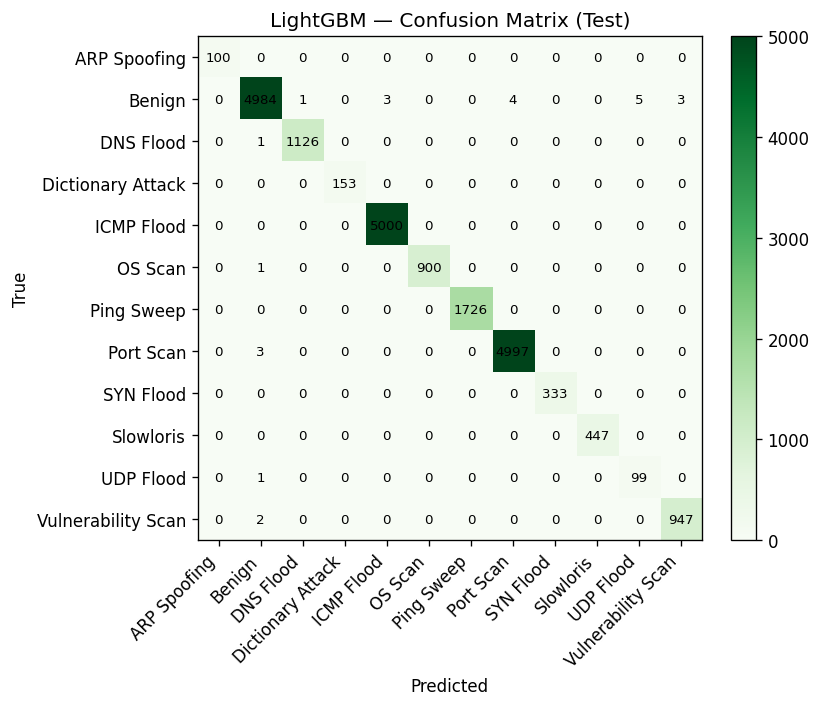

Saved LGBM artifacts to: /content/artifacts


In [15]:
#@title 🧠 LightGBM — train, evaluate, save artifacts
import lightgbm as lgb
import matplotlib.pyplot as plt

train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")
classes = json.loads((OUT_DIR/"classes.json").read_text())
lab2id  = {c:i for i,c in enumerate(classes)}

ytr = train[LABEL_COL].map(lab2id).to_numpy()
yva = val[LABEL_COL].map(lab2id).to_numpy()
yte = test[LABEL_COL].map(lab2id).to_numpy()

# Numeric-only input (already standardized)
NUM_COLS = SELECTED_FEATURES
Xtr = train[NUM_COLS].to_numpy(np.float32)
Xva = val[NUM_COLS].to_numpy(np.float32)
Xte = test[NUM_COLS].to_numpy(np.float32)

lgb_tr = lgb.Dataset(Xtr, label=ytr)
lgb_va = lgb.Dataset(Xva, label=yva, reference=lgb_tr)

params = dict(objective="multiclass", num_class=len(classes), boosting_type="gbdt",
              learning_rate=0.05, num_leaves=48, min_data_in_leaf=64,
              feature_fraction=0.85, bagging_fraction=0.85, bagging_freq=1,
              lambda_l2=1.0, max_bin=255, metric=["multi_logloss","multi_error"],
              seed=RANDOM_STATE, n_jobs=-1, verbosity=-1)

callbacks = [lgb.early_stopping(100, verbose=True), lgb.log_evaluation(100)]
lgbm = lgb.train(params, lgb_tr, valid_sets=[lgb_tr,lgb_va],
                 valid_names=["train","val"], num_boost_round=1200, callbacks=callbacks)

proba = lgbm.predict(Xte, num_iteration=lgbm.best_iteration); np.save(ARTIFACTS_DIR/"lgbm_proba.npy", proba)
y_pred = proba.argmax(1)

acc = accuracy_score(yte,y_pred); mf1 = f1_score(yte,y_pred,average="macro")
print(f"[LGBM] Acc={acc:.4f} | Macro-F1={mf1:.4f}")
print(classification_report(yte,y_pred,target_names=classes,zero_division=0))

cm = confusion_matrix(yte,y_pred,labels=range(len(classes)))
pd.DataFrame(cm, index=classes, columns=classes).to_csv(ARTIFACTS_DIR/"lgbm_confusion_matrix.csv")

fig, ax = plt.subplots(figsize=(7.5,6.0), dpi=120)
im = ax.imshow(cm, cmap="Greens")
ax.set_title("LightGBM — Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right"); ax.set_yticklabels(classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j,i,cm[i,j],ha="center",va="center",fontsize=8)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04); plt.tight_layout()
plt.savefig(ARTIFACTS_DIR/"lgbm_confusion_matrix.png", bbox_inches="tight"); plt.show()

# Save artifacts for app
lgbm.save_model(str(ARTIFACTS_DIR/"lgbm_model.txt"), num_iteration=lgbm.best_iteration)
(ARTIFACTS_DIR/"classes.json").write_text(json.dumps(classes, indent=2))
print("Saved LGBM artifacts to:", ARTIFACTS_DIR)


Ep00 | train 0.8491/0.7708 | val 0.4173/0.8175
Ep01 | train 0.2221/0.9365 | val 0.2629/0.8476
Ep02 | train 0.1522/0.9575 | val 0.1638/0.8871
Ep03 | train 0.1155/0.9696 | val 0.2306/0.8271
Ep04 | train 0.1044/0.9721 | val 0.1560/0.8893
Ep05 | train 0.0963/0.9746 | val 0.1614/0.8905
Ep06 | train 0.0904/0.9759 | val 0.1443/0.8974
Ep07 | train 0.0850/0.9772 | val 0.1549/0.8827
Ep08 | train 0.0826/0.9777 | val 0.1330/0.9084
Ep09 | train 0.0788/0.9790 | val 0.1373/0.9072
Ep10 | train 0.0764/0.9793 | val 0.1321/0.9086
Ep11 | train 0.0739/0.9801 | val 0.1535/0.9009
Ep12 | train 0.0720/0.9803 | val 0.1321/0.9068
Ep13 | train 0.0702/0.9809 | val 0.1349/0.9072
Early stopping.
[FTT] Acc=0.9650 | Macro-F1=0.9149
                    precision    recall  f1-score   support

      ARP Spoofing       0.98      1.00      0.99       100
            Benign       0.99      0.88      0.93      5000
         DNS Flood       1.00      0.99      0.99      1127
 Dictionary Attack       0.58      1.00      0.73 

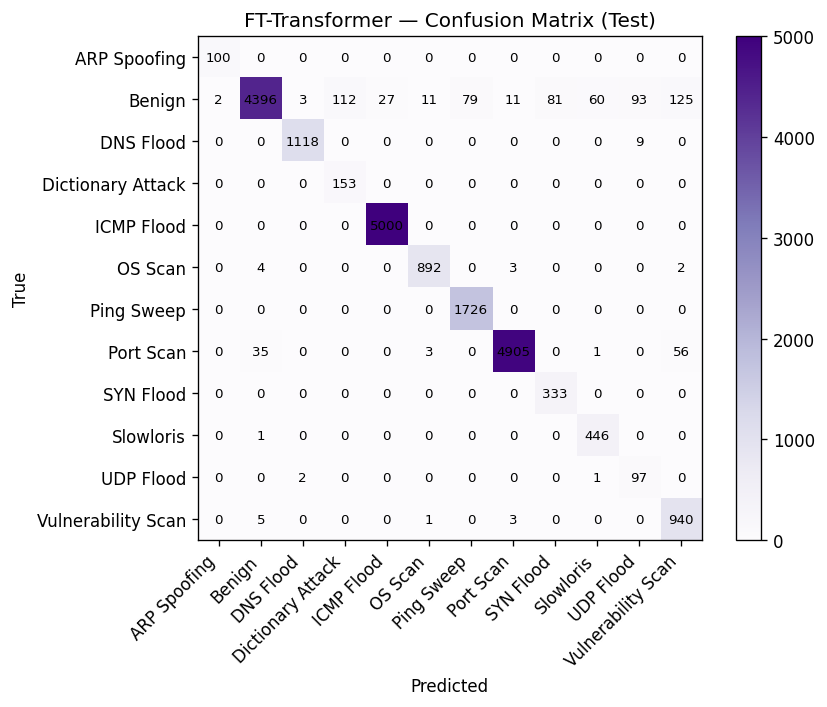

Saved FT-Transformer artifacts to: /content/artifacts/ftt_pure


In [16]:
#@title 🤖 FT-Transformer — train, evaluate, save artifacts
import torch, torch.nn as nn
import matplotlib.pyplot as plt

train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")
classes = json.loads((OUT_DIR/"classes.json").read_text())
lab2id  = {c:i for i,c in enumerate(classes)}
n_classes = len(classes)

def enc_y(s: pd.Series) -> np.ndarray:
    y = s.astype(str).map(lab2id)
    if y.isna().any():
        raise ValueError("Labels outside training classes.")
    return y.astype(int).to_numpy()

ytr, yva, yte = enc_y(train[LABEL_COL]), enc_y(val[LABEL_COL]), enc_y(test[LABEL_COL])

# Numeric-only
NUM_COLS = SELECTED_FEATURES
Xtr = train[NUM_COLS].to_numpy(np.float32)
Xva = val[NUM_COLS].to_numpy(np.float32)
Xte = test[NUM_COLS].to_numpy(np.float32)

class TabDS(torch.utils.data.Dataset):
    def __init__(self,X,y): self.X=torch.tensor(X,dtype=torch.float32); self.y=torch.tensor(y,dtype=torch.long)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self,i): return self.X[i], self.y[i]

BATCH, EPOCHS, PATIENCE = 512, 15, 3
tr_loader = torch.utils.data.DataLoader(TabDS(Xtr,ytr), batch_size=BATCH, shuffle=True,  num_workers=0)
va_loader = torch.utils.data.DataLoader(TabDS(Xva,yva), batch_size=BATCH, shuffle=False, num_workers=0)
te_loader = torch.utils.data.DataLoader(TabDS(Xte,yte), batch_size=BATCH, shuffle=False, num_workers=0)

class FTTransformer(nn.Module):
    def __init__(self, n_num, d=16, heads=2, blocks=2, ff=4, drop=0.1, n_out=2):
        super().__init__()
        self.n_num = n_num
        self.cls   = nn.Parameter(torch.zeros(1,1,d))
        self.num_w = nn.Parameter(torch.randn(n_num, d) * 0.02) if n_num>0 else None
        self.num_b = nn.Parameter(torch.zeros(n_num, d)) if n_num>0 else None
        layer = nn.TransformerEncoderLayer(
            d_model=d, nhead=heads, dim_feedforward=d*ff, dropout=drop,
            batch_first=True, activation="gelu", norm_first=False)
        self.enc  = nn.TransformerEncoder(layer, num_layers=blocks)
        self.head = nn.Sequential(nn.LayerNorm(d), nn.Linear(d, n_out))
    def forward(self, x_num):
        B = x_num.size(0)
        toks = [self.cls.expand(B,1,-1)]
        if self.n_num>0:
            toks.append(x_num.unsqueeze(-1)*self.num_w + self.num_b)
        x = torch.cat(toks, dim=1)
        x = self.enc(x)
        return self.head(x[:,0,:])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = FTTransformer(len(NUM_COLS), n_out=n_classes).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit   = nn.CrossEntropyLoss()

def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total, yh, yt = 0.0, [], []
    for xb,yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train_mode: opt.zero_grad(set_to_none=True)
        logits = model(xb); loss = crit(logits,yb)
        if train_mode:
            loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
        total += loss.item()*yb.size(0)
        yh.append(logits.detach().argmax(1).cpu().numpy()); yt.append(yb.detach().cpu().numpy())
    yh = np.concatenate(yh); yt = np.concatenate(yt)
    return total/len(loader.dataset), f1_score(yt,yh,average="macro")

best, wait, best_state = float("inf"), 0, None
for ep in range(EPOCHS):
    tr_loss,tr_f1 = run_epoch(tr_loader, True)
    va_loss,va_f1 = run_epoch(va_loader, False)
    print(f"Ep{ep:02d} | train {tr_loss:.4f}/{tr_f1:.4f} | val {va_loss:.4f}/{va_f1:.4f}")
    if va_loss < best - 1e-4:
        best, wait, best_state = va_loss, 0, {k:v.cpu() for k,v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= PATIENCE: print("Early stopping."); break

model.load_state_dict(best_state)
model.to(device).eval()

# Test + proba
preds, gts, probas = [], [], []
with torch.no_grad():
    for xb,yb in te_loader:
        xb = xb.to(device)
        logits = model(xb); p = torch.softmax(logits, dim=1)
        preds.append(p.argmax(1).cpu().numpy()); gts.append(yb.numpy()); probas.append(p.cpu().numpy())
y_pred = np.concatenate(preds); yte_ = np.concatenate(gts); proba = np.concatenate(probas)
np.save(ARTIFACTS_DIR/"ftt_proba.npy", proba)

print(f"[FTT] Acc={accuracy_score(yte_,y_pred):.4f} | Macro-F1={f1_score(yte_,y_pred,average='macro'):.4f}")
print(classification_report(yte_, y_pred, target_names=classes, zero_division=0))

cm = confusion_matrix(yte_, y_pred, labels=range(len(classes)))
ftt_dir = ARTIFACTS_DIR/"ftt_pure"; ftt_dir.mkdir(parents=True, exist_ok=True)
pd.DataFrame(cm, index=classes, columns=classes).to_csv(ftt_dir/"ftt_confusion_matrix.csv")
plt.figure(figsize=(7.5,6.0), dpi=120)
plt.imshow(cm, cmap="Purples"); plt.title("FT-Transformer — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right"); plt.yticks(range(len(classes)), classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center",fontsize=8)
plt.colorbar(); plt.tight_layout(); plt.savefig(ftt_dir/"ftt_confusion_matrix.png", bbox_inches="tight"); plt.show()

# Save bundle for app
torch.save(model.state_dict(), ftt_dir/"model.pt")
(ftt_dir/"meta.json").write_text(json.dumps(
    {"label_col": LABEL_COL, "classes": classes, "cat_cols": [], "num_cols": NUM_COLS,
     "model_hparams": {"d_token":16,"n_heads":2,"n_blocks":2,"ff_mult":4,"dropout":0.1,"n_classes":len(classes)}},
    indent=2))
joblib.dump(joblib.load(OUT_DIR/"ftt_scaler.joblib"), ftt_dir/"ftt_scaler.joblib")
(ARTIFACTS_DIR/"classes.json").write_text(json.dumps(classes, indent=2))
print("Saved FT-Transformer artifacts to:", ftt_dir)


Ep00 train=0.3684 val=0.2780
Ep01 train=0.1298 val=0.1473
Ep02 train=0.0913 val=0.1334
Ep03 train=0.0774 val=0.1211
Ep04 train=0.0690 val=0.1147
Ep05 train=0.0629 val=0.1057
Ep06 train=0.0592 val=0.1076
Ep07 train=0.0561 val=0.1027
Ep08 train=0.0535 val=0.0936
Ep09 train=0.0508 val=0.0927
Ep10 train=0.0482 val=0.0889
Ep11 train=0.0461 val=0.0899
Ep12 train=0.0458 val=0.0917
Ep13 train=0.0443 val=0.0836
Ep14 train=0.0419 val=0.0915
Ep15 train=0.0412 val=0.0826
Ep16 train=0.0400 val=0.0836
Ep17 train=0.0392 val=0.0795
Ep18 train=0.0381 val=0.0794
Ep19 train=0.0364 val=0.0966
[MLP] Acc=0.9800 | Macro-F1=0.9516
                    precision    recall  f1-score   support

      ARP Spoofing       0.95      1.00      0.98       100
            Benign       0.99      0.94      0.97      5000
         DNS Flood       0.99      0.99      0.99      1127
 Dictionary Attack       0.85      1.00      0.92       153
        ICMP Flood       1.00      1.00      1.00      5000
           OS Scan      

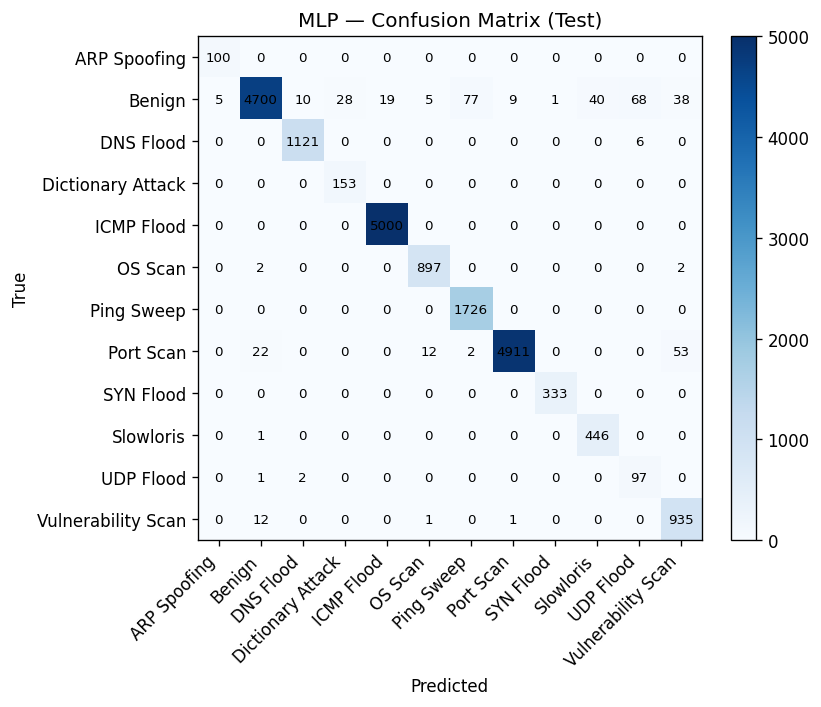

Saved MLP artifacts to: /content/artifacts


In [17]:
#@title 🧠 MLP — train, evaluate, save artifacts
import torch, torch.nn as nn
import matplotlib.pyplot as plt

train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")
classes = json.loads((OUT_DIR/"classes.json").read_text())
lab2id  = {c:i for i,c in enumerate(classes)}

ytr = train[LABEL_COL].map(lab2id).to_numpy()
yva = val[LABEL_COL].map(lab2id).to_numpy()
yte = test[LABEL_COL].map(lab2id).to_numpy()

NUM_COLS = SELECTED_FEATURES
Xtr = train[NUM_COLS].to_numpy(np.float32)
Xva = val[NUM_COLS].to_numpy(np.float32)
Xte = test[NUM_COLS].to_numpy(np.float32)

class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=512, drop=0.2, n_out=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in,d_hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(d_hidden,d_hidden//2), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(d_hidden//2,n_out)
        )
    def forward(self,x): return self.net(x)

def to_loader(X,y,batch=512,shuffle=False):
    ds = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),
                                        torch.tensor(y, dtype=torch.long))
    return torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=shuffle)

tr_loader = to_loader(Xtr,ytr,shuffle=True); va_loader = to_loader(Xva,yva); te_loader = to_loader(Xte,yte)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = MLP(Xtr.shape[1], n_out=len(classes)).to(device)
opt, crit = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4), nn.CrossEntropyLoss()

best=float("inf"); wait=0
for ep in range(20):
    model.train(); tl=0.0
    for xb,yb in tr_loader:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        loss = crit(model(xb), yb); loss.backward(); opt.step()
        tl += loss.item()*yb.size(0)
    tl /= len(tr_loader.dataset)
    model.eval(); vl=0.0
    with torch.no_grad():
        for xb,yb in va_loader:
            xb,yb = xb.to(device), yb.to(device)
            vl += crit(model(xb), yb).item()*yb.size(0)
    vl/=len(va_loader.dataset)
    print(f"Ep{ep:02d} train={tl:.4f} val={vl:.4f}")
    if vl<best-1e-4: best=vl; wait=0; torch.save(model.state_dict(), ARTIFACTS_DIR/"mlp.pt")
    else:
        wait+=1
        if wait>=3: print("Early stop"); break

# Test + proba
model.load_state_dict(torch.load(ARTIFACTS_DIR/"mlp.pt", map_location=device))
model.eval()
preds, gts, probas = [], [], []
with torch.no_grad():
    for xb,yb in te_loader:
        xb = xb.to(device)
        logits = model(xb); p = torch.softmax(logits, dim=1).cpu().numpy()
        probas.append(p); preds.append(p.argmax(1)); gts.append(yb.numpy())
proba = np.concatenate(probas); np.save(ARTIFACTS_DIR/"mlp_proba.npy", proba)
y_pred = np.concatenate(preds); yte_ = np.concatenate(gts)

print(f"[MLP] Acc={accuracy_score(yte_,y_pred):.4f} | Macro-F1={f1_score(yte_,y_pred,average='macro'):.4f}")
print(classification_report(yte_,y_pred,target_names=classes,zero_division=0))

cm = confusion_matrix(yte_,y_pred,labels=range(len(classes)))
pd.DataFrame(cm, index=classes, columns=classes).to_csv(ARTIFACTS_DIR/"mlp_confusion_matrix.csv")
fig, ax = plt.subplots(figsize=(7.5,6.0), dpi=120)
im = ax.imshow(cm, cmap="Blues"); ax.set_title("MLP — Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right"); ax.set_yticklabels(classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]): ax.text(j,i,cm[i,j],ha="center",va="center",fontsize=8)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04); plt.tight_layout()
plt.savefig(ARTIFACTS_DIR/"mlp_confusion_matrix.png", bbox_inches="tight"); plt.show()

(ARTIFACTS_DIR/"classes.json").write_text(json.dumps(classes, indent=2))
(ARTIFACTS_DIR/"mlp_meta.json").write_text(json.dumps({"input_dim": int(Xtr.shape[1])}, indent=2))
print("Saved MLP artifacts to:", ARTIFACTS_DIR)


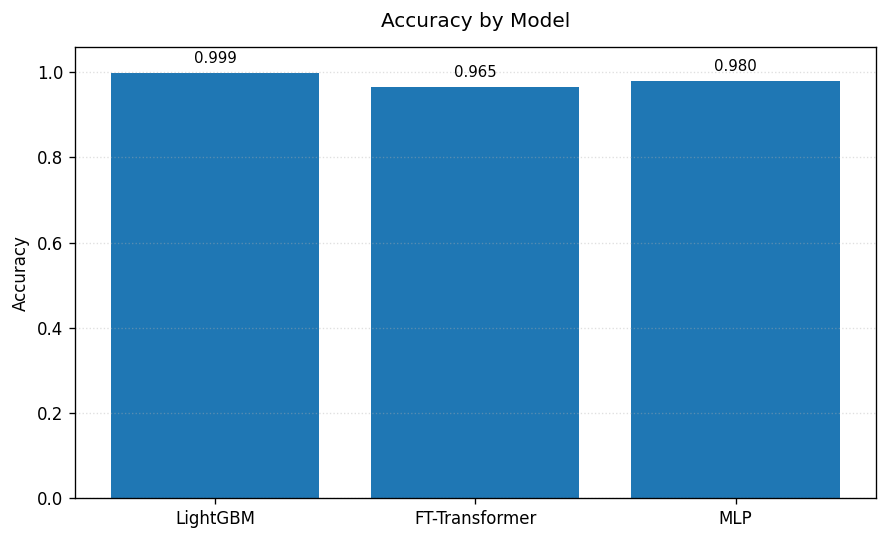

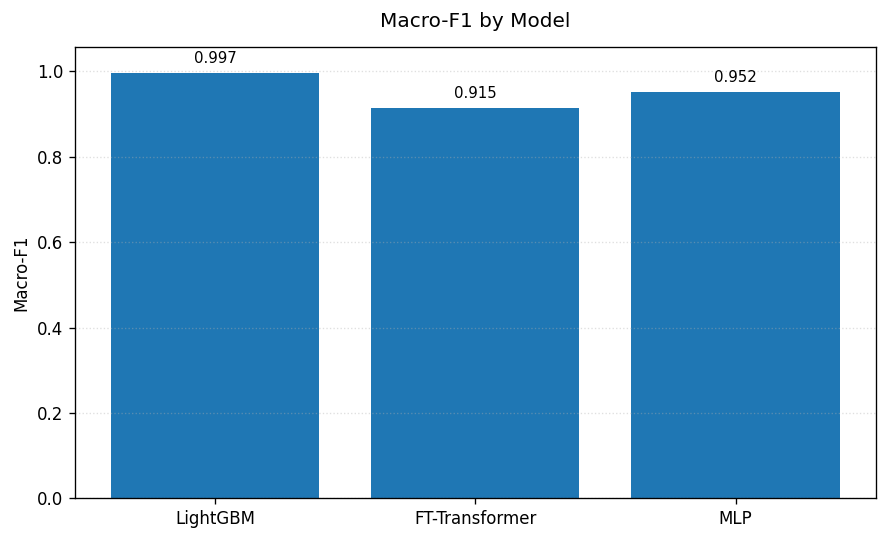

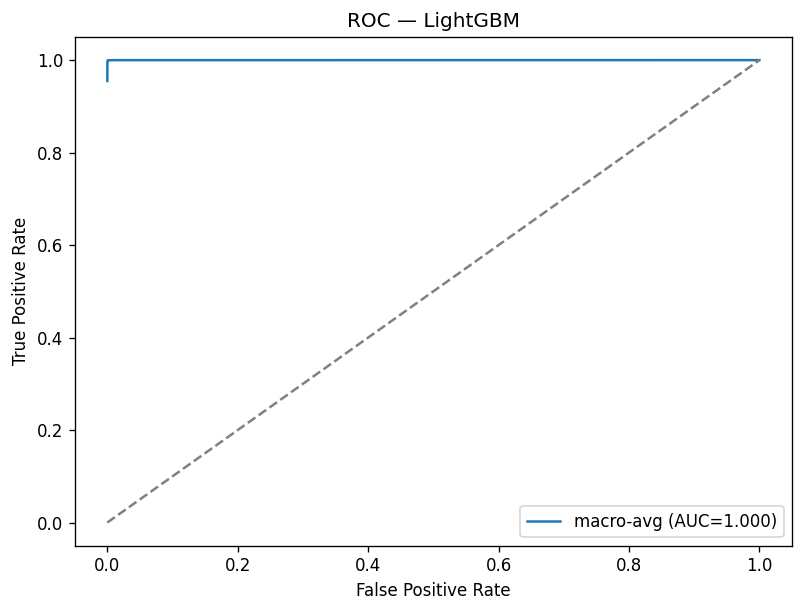

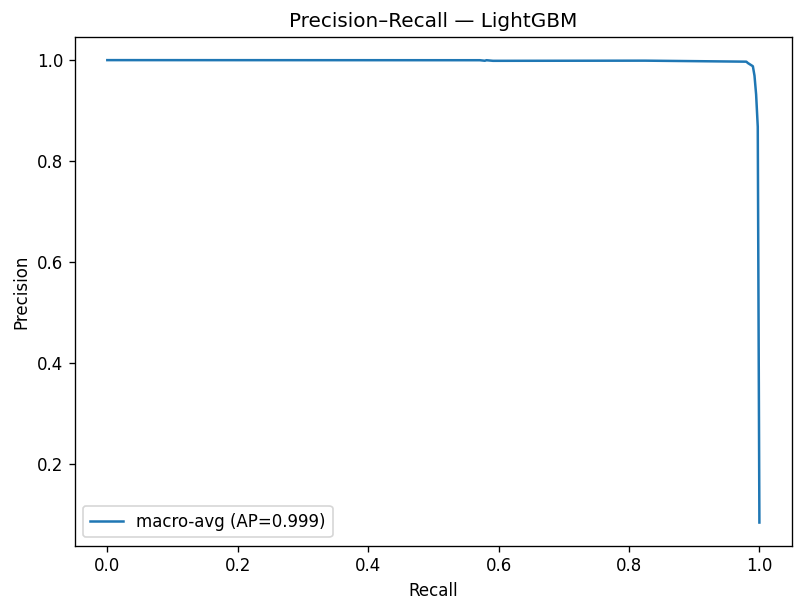

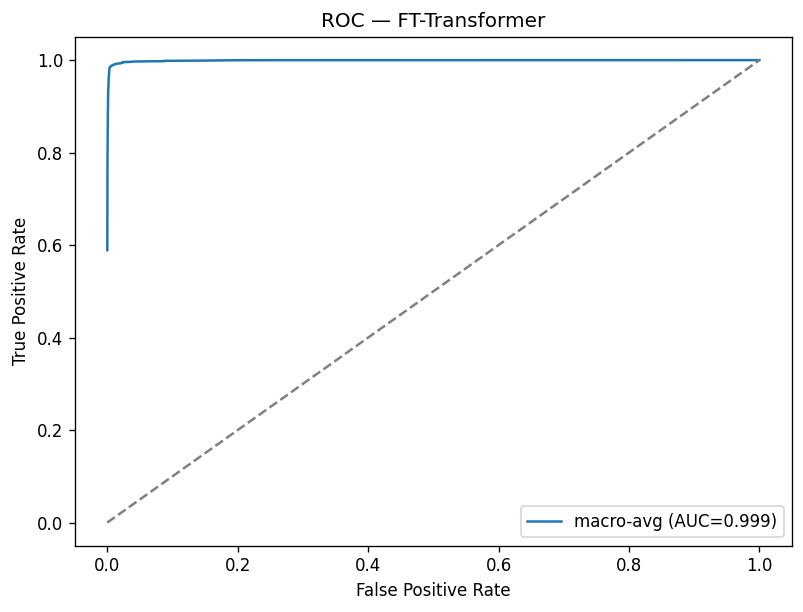

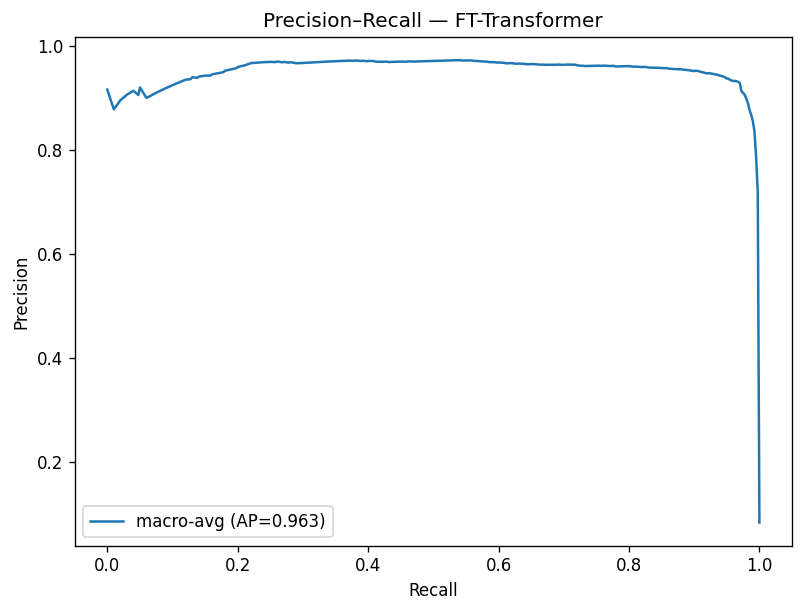

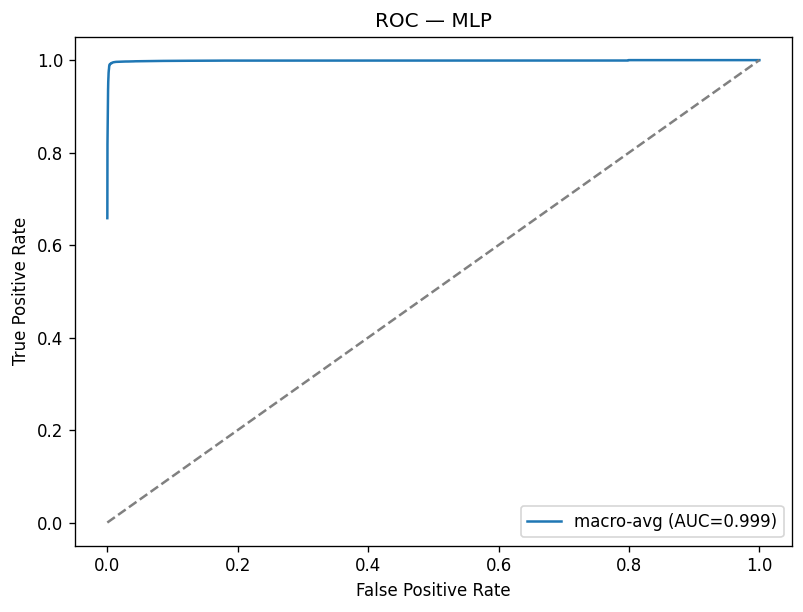

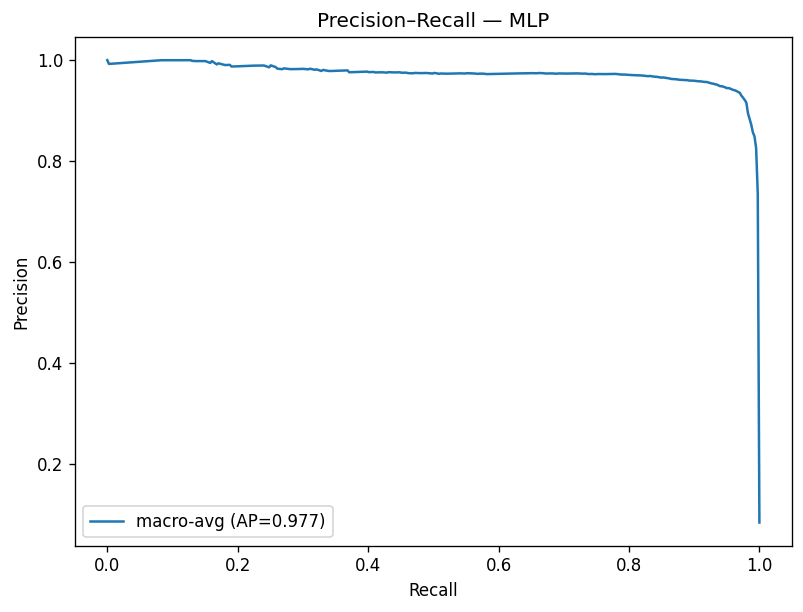

✅ Saved summary charts to /content/artifacts


In [18]:
#@title 📊 Performance summary + ROC/PR (uses saved CMs & proba)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

classes = json.loads((ARTIFACTS_DIR/"classes.json").read_text())
n_classes = len(classes); cls2id = {c:i for i,c in enumerate(classes)}
test = pd.read_csv(OUT_DIR/"ftt_test.csv")
y_true = test[LABEL_COL].astype(str).map(cls2id).to_numpy()

def metrics_from_cm(cm: np.ndarray):
    tp = np.diag(cm); fp = cm.sum(0)-tp; fn = cm.sum(1)-tp
    with np.errstate(divide="ignore", invalid="ignore"):
        prec = np.where(tp+fp>0, tp/(tp+fp), 0.0)
        rec  = np.where(tp+fn>0, tp/(tp+fn), 0.0)
        f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
    return (tp.sum()/cm.sum(), float(np.mean(f1)))

cms = {}
for name, path in {
    "LightGBM": ARTIFACTS_DIR/"lgbm_confusion_matrix.csv",
    "FT-Transformer": ARTIFACTS_DIR/"ftt_pure"/"ftt_confusion_matrix.csv",
    "MLP": ARTIFACTS_DIR/"mlp_confusion_matrix.csv",
}.items():
    if path.exists():
        cms[name] = pd.read_csv(path, index_col=0).values

summary = {}
for k, cm in cms.items():
    acc, macro_f1 = metrics_from_cm(cm)
    summary[k] = (acc, macro_f1)

# Bar plots (accuracy & macro-F1)
for metric_i, title, fname in [(0,"Accuracy by Model","perf_accuracy_by_model.png"),
                               (1,"Macro-F1 by Model","perf_macrof1_by_model.png")]:
    s = pd.Series({k:v[metric_i] for k,v in summary.items()})
    fig, ax = plt.subplots(figsize=(7.5,4.6), dpi=120)
    bars = ax.bar(s.index, s.values); ax.set_ylim(0, max(1.0, s.max()+0.06))
    ax.set_ylabel(title.split()[0]); ax.set_title(title, pad=12); ax.grid(axis='y', linestyle=':', alpha=0.4)
    ax.bar_label(bars, labels=[f"{v:.3f}" for v in s.values], padding=4, fontsize=9)
    plt.tight_layout(); plt.savefig(ARTIFACTS_DIR/fname, bbox_inches="tight"); plt.show()

# ROC/PR (macro) for each model with proba
def plot_roc_pr(model_name, proba_path):
    if not proba_path.exists(): return
    proba = np.load(proba_path)
    Y = label_binarize(y_true, classes=list(range(n_classes)))
    # ROC macro
    fpr_all = []; tpr_all = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y[:,i], proba[:,i])
        fpr_all.append(fpr); tpr_all.append(tpr)
    grid = np.unique(np.concatenate(fpr_all))
    mean_tpr = np.zeros_like(grid)
    for fpr, tpr in zip(fpr_all, tpr_all):
        mean_tpr += np.interp(grid, fpr, tpr)
    mean_tpr /= max(n_classes,1)
    auc_macro = auc(grid, mean_tpr)
    fig, ax = plt.subplots(figsize=(6.8,5.2), dpi=120)
    ax.plot(grid, mean_tpr, label=f"macro-avg (AUC={auc_macro:.3f})"); ax.plot([0,1],[0,1],"--",color="gray")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate"); ax.set_title(f"ROC — {model_name}")
    ax.legend(); plt.tight_layout(); plt.savefig(ARTIFACTS_DIR/f"roc_{model_name.lower().replace('-','_')}.png", bbox_inches="tight"); plt.show()
    # PR macro
    grid = np.linspace(0,1,400); pr_curves=[]
    aps=[]
    for i in range(n_classes):
        pr, rc, _ = precision_recall_curve(Y[:,i], proba[:,i])
        order = np.argsort(rc); pr_curves.append(np.interp(grid, rc[order], pr[order]))
        aps.append(average_precision_score(Y[:,i], proba[:,i]))
    mean_pr = np.mean(pr_curves, axis=0); ap_macro = np.mean(aps)
    fig, ax = plt.subplots(figsize=(6.8,5.2), dpi=120)
    ax.plot(grid, mean_pr, label=f"macro-avg (AP={ap_macro:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title(f"Precision–Recall — {model_name}"); ax.legend()
    plt.tight_layout(); plt.savefig(ARTIFACTS_DIR/f"pr_{model_name.lower().replace('-','_')}.png", bbox_inches="tight"); plt.show()

plot_roc_pr("LightGBM", ARTIFACTS_DIR/"lgbm_proba.npy")
plot_roc_pr("FT-Transformer", ARTIFACTS_DIR/"ftt_proba.npy")
plot_roc_pr("MLP", ARTIFACTS_DIR/"mlp_proba.npy")
print("✅ Saved summary charts to", ARTIFACTS_DIR)


In [21]:
#@title 📦 Zip preprocessed_iot/ and artifacts/
from google.colab import files
for path, zname in [(OUT_DIR, "/content/preprocessed_iot.zip"),
                    (ARTIFACTS_DIR, "/content/artifacts.zip")]:
    shutil.make_archive(zname.replace(".zip",""), "zip", path)
    files.download(zname)
print("Zips ready at /content/*.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zips ready at /content/*.zip
